### Exercise 1

In [1]:
from bidict import bidict
from datetime import datetime
import numpy as np
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn import datasets, metrics

In [2]:
# %matplotlib qt

In [3]:
X_y = np.load('skewed_MNIST.npy')
X = X_y[:,:-1]
y = X_y[:,-1]
print(X.shape,y.shape)

(12244, 784) (12244,)


Text(0, 0.5, 'frequency')

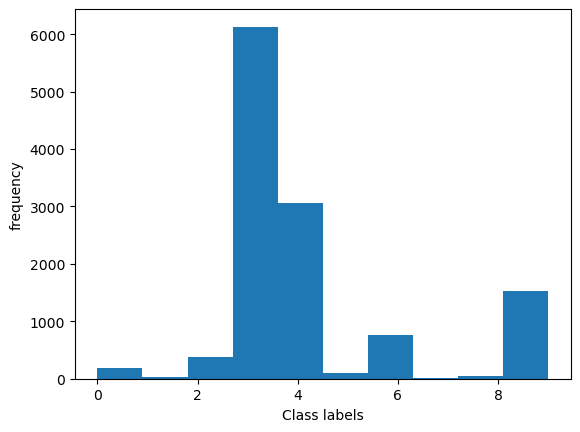

In [4]:
plt.hist(y)
plt.xlabel('Class labels')
plt.ylabel('frequency')

In [5]:
# Using only X, come up with some method to assign an "anomalousness score" to each point (from scratch)
count = np.zeros([X.shape[0],2])

for i in range(X.shape[0]):
    count[i,1] = y[i]
    for j in range(X.shape[1]):
        if(X[i,j] > 128 ):
            count[i,0] += 1
            

In [6]:
print(count)

[[ 88.   7.]
 [127.   7.]
 [ 85.   7.]
 ...
 [ 85.   3.]
 [ 92.   3.]
 [117.   3.]]


In [7]:
mean = np.mean(count[:,0])

(array([ 237., 1852., 3526., 3414., 2000.,  875.,  256.,   64.,   16.,
           4.]),
 array([ 30. ,  53.1,  76.2,  99.3, 122.4, 145.5, 168.6, 191.7, 214.8,
        237.9, 261. ]),
 <BarContainer object of 10 artists>)

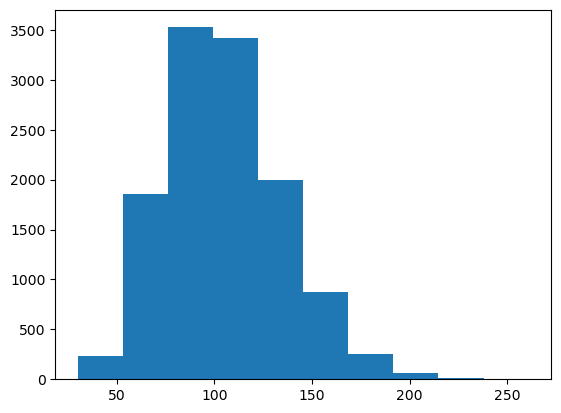

In [8]:
plt.hist(count[:,0])

In [9]:
difference = np.zeros(count.shape)
difference[:,1] = count[:,1]

for i in range(len(count)):
    difference[i,0] = (count[i,0] - mean) ** 2

In [10]:
sorted_indices = np.argsort(difference[:, 0])
difference_sorted = difference[sorted_indices]

print(difference_sorted[:500, :])

[[0.06075637 3.        ]
 [0.06075637 2.        ]
 [0.06075637 2.        ]
 [0.06075637 9.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 9.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 4.        ]
 [0.06075637 3.        ]
 [0.06075637 4.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 9.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 9.        ]
 [0.06075637 4.        ]
 [0.06075637 3.        ]
 [0.06075637 3.        ]
 [0.06075637 4.        ]
 [0.06075637 3.        ]
 [0.06075637 4.        ]
 [0.06075637 3.        ]
 [0.06075637 9.        ]
 [0.06075637 4.        ]
 [0.06075637 2.        ]
 [0.06075637 2.        ]
 [0.06075637 9.        ]
 [0.06075637 3.        ]
 [0.06075637 6.        ]
 [0.06075637 3.        ]
 [0.06075637 9.        ]
 [0.06075637 3.        ]
 [0.06075637 9.        ]


In [11]:
# Using y, calculate the probabilities of each class
unique, counts = np.unique(y, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[ 191   23  383 6131 3065   95  766   11   47 1532]


In [12]:
labels = np.vstack((unique,counts))

In [13]:
print(labels)
print(labels.shape)

[[0.000e+00 1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00
  7.000e+00 8.000e+00 9.000e+00]
 [1.910e+02 2.300e+01 3.830e+02 6.131e+03 3.065e+03 9.500e+01 7.660e+02
  1.100e+01 4.700e+01 1.532e+03]]
(2, 10)


In [14]:
labels = labels.T

In [15]:
sorted_indices = np.argsort(labels[:, 1])
labels = labels[sorted_indices]

print(labels)

[[7.000e+00 1.100e+01]
 [1.000e+00 2.300e+01]
 [8.000e+00 4.700e+01]
 [5.000e+00 9.500e+01]
 [0.000e+00 1.910e+02]
 [2.000e+00 3.830e+02]
 [6.000e+00 7.660e+02]
 [9.000e+00 1.532e+03]
 [4.000e+00 3.065e+03]
 [3.000e+00 6.131e+03]]


In [16]:
total = np.sum(labels[:,1])

probabilities = np.zeros(shape= (10,1))

probabilities = labels[:, 1] / total

print('Probabilities for Each Class:\n')
for i in range(len(probabilities)):
    print(f'Class {labels[i,0]}: {probabilities[i]:.4f}')

Probabilities for Each Class:

Class 7.0: 0.0009
Class 1.0: 0.0019
Class 8.0: 0.0038
Class 5.0: 0.0078
Class 0.0: 0.0156
Class 2.0: 0.0313
Class 6.0: 0.0626
Class 9.0: 0.1251
Class 4.0: 0.2503
Class 3.0: 0.5007


In [17]:
# Assuming the "correct" answer would be to have the anomalousness ranking match the ordering of the 
# class probability, calculate the accuracy of your method 

true_labels = np.zeros(shape = (int(total), 1))

true_labels[:6131] = 3
true_labels[6131:9196] = 4
true_labels[9196:10728] = 9
true_labels[10728:11494] = 6
true_labels[11494:11877] = 2
true_labels[11877:12068] = 0
true_labels[12068:12163] = 5
true_labels[12163:12210] = 8
true_labels[12210:12233] = 1
true_labels[12233:] = 7

correct_vals = np.zeros(shape = (int(total), 1))    

for i in range(len(correct_vals)):
    if(true_labels[i] == difference_sorted[i,1]):
        correct_vals[i] = 1
        
correct_guesses = np.sum(correct_vals)
accuracy = correct_guesses / total
accuracy = accuracy * 100

print(f'Accuracy Using Counts: {accuracy:.4f}%')


Accuracy Using Counts: 33.9513%


# Random Simulation

In [26]:
m = 10000
results = np.zeros(shape = (m, 1))

def simulateRandomAnomalyMNIST(m, results, labels):
    length = len(labels)
    randVals = np.zeros(shape = (length, 1))
    
    for i in range(length):
        randVals[i] = np.random.randint(0,10)
    
    for i in range(m):
        np.random.shuffle(randVals)
        correct_vals = np.zeros(shape = (length, 1))    

        for j in range(len(correct_vals)):
            if(labels[j] == randVals[j]):
                correct_vals[j] = 1
                
        results[i] = np.sum(correct_vals) / length
        
    return results

        
accuracies = simulateRandomAnomalyMNIST(m, results, true_labels)

simulationAccuracy = np.average(accuracies)
simulationAccuracy = simulationAccuracy * 100

print(f'Random Simulation Accuracy with {m} Iteration: {simulationAccuracy:.4f}%')
        

Random Simulation Accuracy with 10000 Iteration: 9.9995%
